In [1]:
import re
from ast import literal_eval #faster than pd.eval

import pandas as pd
import numpy as np
import demoji
# import nltk
from nltk import FreqDist 
from nltk.tokenize import RegexpTokenizer  
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# run if not available
# nltk.download('stopwords')
# nltk.download('vader_lexicon')

In [3]:
df = pd.read_csv("bellroy.csv")
df.head()

,title,selftext,comments,comment_upvotes,comments_utc,upvotes,time_stamp
0,Bellroy’s return policy,So I got one of their lite mini slings due to ...,"[""Really sorry you're going through this, nigh...","[143, 44, 75, 33, 16, 13, 10, 23, 6, 12, 6, 8,...","['2024-04-16 09:24:25', '2024-04-16 09:43:34',...",224,2024-04-16 08:44:47
1,Bellroy Premium Wallet Review after owning a p...,NaN,['My dad bought me a $20 leather wallet from t...,"[86, 17, 29, 43, 7, 6, 5, 5, 3, 3, 3, 3, 4, 2,...","['2022-07-27 18:55:57', '2022-07-27 18:55:40',...",304,2022-07-27 17:31:17
2,Bellroy - Are they worth the money?,"The more I look into their bags, the more it m...","[""It's amazing how fast quality tends to nose ...","[62, 60, 13, 12, 15, 5, 6, 5, 8, 3, 3, 3, 5, 2...","['2024-05-27 22:26:12', '2024-05-27 22:17:50',...",20,2024-05-27 22:12:12
3,Is bellroy low quality?,NaN,['Anyone who knows leather will avoid BellRoy....,"[6, 3, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","['2021-08-25 11:50:05', '2021-08-25 15:39:20',...",24,2021-08-25 09:55:40
4,"Bellroy, what’s the big deal about it ?","So, why so expensive? How long they have been ...",['I have a couple Bellroy bags they are very w...,"[12, 8, 6, 14, 4, 3, 3, 1, 1, 1, 1, 1, 1, 3]","['2023-11-03 19:02:25', '2023-11-03 19:52:31',...",12,2023-11-03 18:52:31


In [4]:
len(df['title'])-len(df['title'].drop_duplicates())


9

### DATA PREPROCESSING

In [5]:
df.shape

(248, 7)

In [6]:
df.isna().sum()

title               0
selftext           45
comments            0
comment_upvotes     0
comments_utc        0
upvotes             0
time_stamp          0
dtype: int64

In [7]:
df = df.fillna(" ")
df.isna().sum()

title              0
selftext           0
comments           0
comment_upvotes    0
comments_utc       0
upvotes            0
time_stamp         0
dtype: int64

In [8]:
# find better way (shorter) to do this
comment_list = []
for comment in df['comments']:
#     print(type(comment))
    comment = literal_eval(comment)
    comment_list.append(comment)
    
df['comments_list'] = comment_list 

In [9]:
def clean_text(text):
    tokenizer = RegexpTokenizer('\w+|\$[\d\.]+http\S+')
    stops = set(stopwords.words('english'))
    other = ['bellroy','reddit','bag', 'one','venture'] #words added with trial and error
    lemmatizer = WordNetLemmatizer()
    
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = re.sub(r'\[.*?\]', '', text)  # Remove text in brackets
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = demoji.replace(text, '')
    text = text.lower()  # Convert to lowercase
    text = tokenizer.tokenize(text)
    text = [w for w in text if w not in stops]
    text = [w for w in text if w not in other]
    text = [lemmatizer.lemmatize(w) for w in text]
    return text

In [10]:
df['title'] = df['title'].apply(clean_text)
df['selftext'] = df['selftext'].apply(clean_text)
df['comments_list'] = df['comments_list'].apply(lambda comments: [clean_text(comment) for comment in comments])
df.head()

,title,selftext,comments,comment_upvotes,comments_utc,upvotes,time_stamp,comments_list
0,"[return, policy]","[got, lite, mini, sling, due, sale, receiving,...","[""Really sorry you're going through this, nigh...","[143, 44, 75, 33, 16, 13, 10, 23, 6, 12, 6, 8,...","['2024-04-16 09:24:25', '2024-04-16 09:43:34',...",224,2024-04-16 08:44:47,"[[really, sorry, going, nightmare, many, accou..."
1,"[premium, wallet, review, owning, previous, de...",[],['My dad bought me a $20 leather wallet from t...,"[86, 17, 29, 43, 7, 6, 5, 5, 3, 3, 3, 3, 4, 2,...","['2022-07-27 18:55:57', '2022-07-27 18:55:40',...",304,2022-07-27 17:31:17,"[[dad, bought, 20, leather, wallet, brand, str..."
2,"[worth, money]","[look, bag, make, wonder, make, expensive, spe...","[""It's amazing how fast quality tends to nose ...","[62, 60, 13, 12, 15, 5, 6, 5, 8, 3, 3, 3, 5, 2...","['2024-05-27 22:26:12', '2024-05-27 22:17:50',...",20,2024-05-27 22:12:12,"[[amazing, fast, quality, tends, nose, dive, s..."
3,"[low, quality]",[],['Anyone who knows leather will avoid BellRoy....,"[6, 3, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","['2021-08-25 11:50:05', '2021-08-25 15:39:20',...",24,2021-08-25 09:55:40,"[[anyone, know, leather, avoid, mass, produced..."
4,"[big, deal]","[expensive, long, around, started, see, ad, on...",['I have a couple Bellroy bags they are very w...,"[12, 8, 6, 14, 4, 3, 3, 1, 1, 1, 1, 1, 1, 3]","['2023-11-03 19:02:25', '2023-11-03 19:52:31',...",12,2023-11-03 18:52:31,"[[couple, bag, well, made, specific, look, app..."


### SENTIMENT ANALYSIS WITH NLTK

In [11]:
sia = SentimentIntensityAnalyzer()

title_score = df['title'].apply(lambda x: [sia.polarity_scores(w).get('compound') for w in x])
selftext_score = df['selftext'].apply(lambda x: [sia.polarity_scores(w).get('compound') for w in x])
comments_score = df['comments_list'].apply(lambda x: [sia.polarity_scores(w).get('compound') for lists in x for w in lists ])

In [12]:
df['pool_score'] = title_score + selftext_score + comments_score

In [13]:
df['label'] = 0
df.loc[df['pool_score'].apply(lambda x: np.mean(x) > 0.0), 'label'] = 1
df.loc[df['pool_score'].apply(lambda x: np.mean(x) < 0.0), 'label'] = -1

In [14]:
df.label.value_counts()

 1    237
 0      8
-1      3
Name: label, dtype: int64

### VISUALISATION

In [15]:
def flatten(nested_list):
    return [item for sublist in nested_list for item in (sublist if isinstance(sublist, list) else [sublist])]

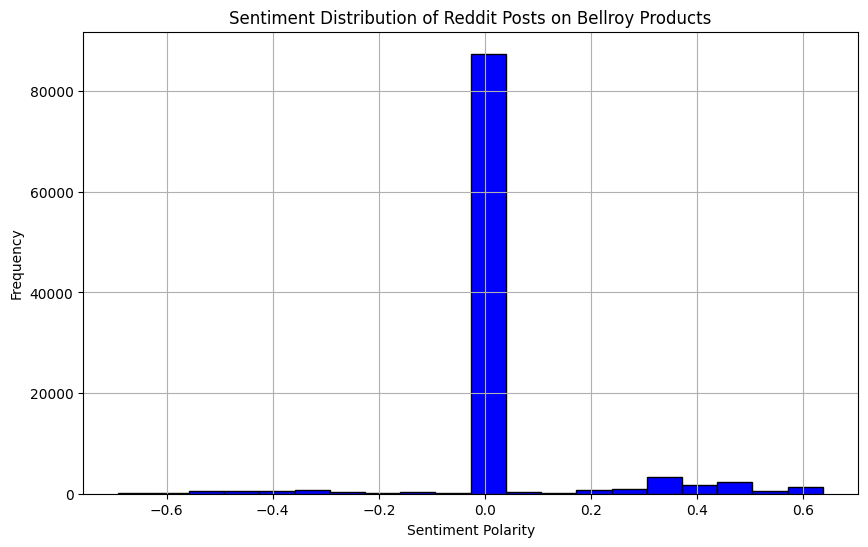

In [16]:
score_list= flatten(df['pool_score'].tolist())

plt.figure(figsize=(10, 6))
plt.hist(score_list, bins=20, color='blue', edgecolor='black')
plt.title('Sentiment Distribution of Reddit Posts on Bellroy Products')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

/var/folders/_6/k19_kjb552v4gfyyb6dyg1n40000gn/T/ipykernel_33796/3274043637.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])


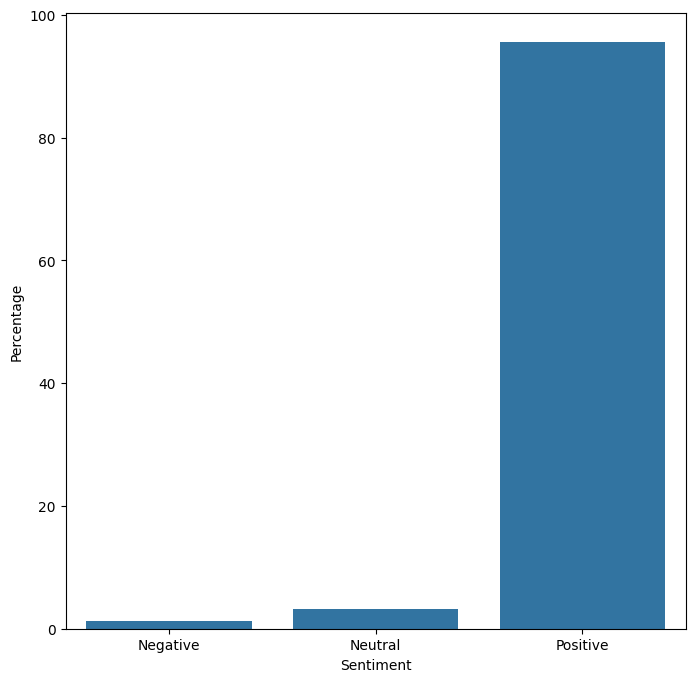

In [17]:
fig, ax = plt.subplots(figsize=(8,8))

counts = df.label.value_counts(normalize=True) * 100

sns.barplot(x=counts.index, y=counts, ax=ax)

ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_xlabel('Sentiment')
ax.set_ylabel('Percentage')

plt.show()

In [18]:
df['all_words'] = df['title'] + df['selftext'] + df['comments_list']
df['all_words_flatten'] = df['all_words'].apply(flatten)

In [19]:
all_words = " ".join(x for x in df['all_words_flatten'].apply(lambda x: " ".join(x))).split(" ")
positive_words = " ".join(x for x in df[df['label'] == 1]['all_words_flatten'].apply(lambda x: " ".join(x))).split(" ")
negative_words = " ".join(x for x in df[df['label'] == -1]['all_words_flatten'].apply(lambda x: " ".join(x))).split(" ")

pos_freq = FreqDist(positive_words).most_common(5)
neg_freq = FreqDist(negative_words).most_common(5)
print('pos_freq\n', pos_freq)
print('neg_freq\n', neg_freq)

pos_freq
 [('like', 1333), ('case', 855), ('sling', 826), ('look', 757), ('would', 581)]
neg_freq
 [('warranty', 7), ('3', 6), ('price', 6), ('side', 5), ('year', 5)]


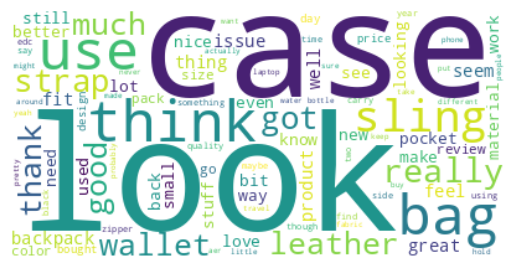

In [20]:
wordcloud_total = WordCloud(background_color="white").generate(" , ".join(all_words))
plt.imshow(wordcloud_total, interpolation='bilinear')
plt.axis('off')
plt.show()

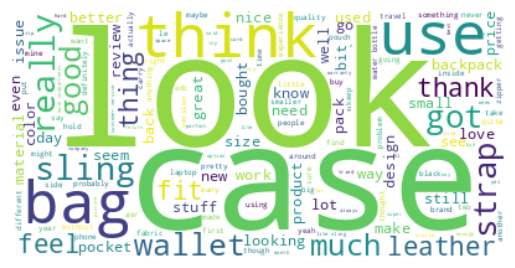

In [21]:
wordcloud_posit = WordCloud(background_color="white").generate(" , ".join(positive_words))
plt.imshow(wordcloud_posit, interpolation='bilinear')
plt.axis('off')
plt.show()

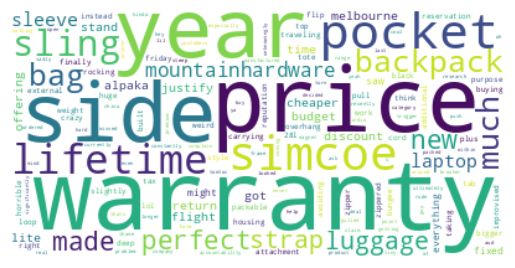

In [22]:
wordcloud_negat = WordCloud(background_color="white").generate(" , ".join(negative_words))
plt.imshow(wordcloud_negat, interpolation='bilinear')
plt.axis('off')
plt.show()